Import relevant Python packages

Then, extract Foursquare venues data for each city and neighborhood region: San Francisco / SoMa and Seattle / Pioneer Square.

In [1]:
import numpy as np
from numpy import genfromtxt

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7

import os, sys, urllib
from urllib.request import urlopen

import requests, csv, json   # Libraries for HTTP requests and reading external files with CSV or JSON data (also: xml)
# from bs4 import BeautifulSoup
import math, random   # Libraries for Math and Random Number generation
print("Initial packages imported: \nNumPy, Pandas, Matplotlib, Seaborn, Requests, JSON, CSV, Math, Random.")

Initial packages imported: 
NumPy, Pandas, Matplotlib, Seaborn, Requests, JSON, CSV, Math, Random.


In [2]:
from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# Tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# module to convert an address into latitude and longitude values
# !conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 
print("GeoPy.Geocoders.Nominatim installed.")

# Libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
print("IPython Image and HTML installed.")

# !conda install -c conda-forge folium=0.5.0 --yes
import folium 
from folium import plugins

print("\nSecond set of libraries imported: \nKMeans, DBSCAN, Counter, JSON_Normalize, Geocoders-Nominatum, Image, HTML, Folium.")

GeoPy.Geocoders.Nominatim installed.
IPython Image and HTML installed.

Second set of libraries imported: 
KMeans, DBSCAN, Counter, JSON_Normalize, Geocoders-Nominatum, Image, HTML, Folium.


In [3]:
# Check the network folder for locating this Python Jupyter Notebook and all the dataset files.

# os.chdir('C:/Users/Thor-from-Asgard/.ipynb_checkpoints')
# os.getcwd()

Define functions to retrieve and display venues information: 
1. Foursquare venues information: venue category (get_category_type());  access nearby venues (getNearbyVenues())
2. DBSCAN clustering algorithm / epsilon parameter calculation (epsilon())
3. Folium Map functions to display: map with markers (mapMarkers());  map showing the machine learning data clusters (clusterMap())

In [4]:
# Foursquare: the function get_category_type below retrieves a venue's category type.
# From our Foursquare lab, we know that all the venue information is in the items key. 
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [5]:
# Foursquare API: access JSON object of venues listed in Foursquare based on Latitude-Longitude point and radius
# Example function call syntax for getNearbyVenues():
#  df_SF = getNearbyVenues('SF_SoMa', latitude_SFSoMa, longitude_SFSoMa, radius)

# Foursquare returns the venues results in a JSON object. 
#  I convert the JSON object to a Pandas DataFrame and structure the dataframe with these five columns:
#  Location (Neighborhood: SF_SoMa or SEA_PioneerSq), Venue Name (business establishment name), Latitude, Longitude, Venue Category

def getNearbyVenues(name, latitude, longitude, radius):
    
    venues_list=[]
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude, 
        radius, 
        500)
            
    # Make the HTTP GET request to the Foursquare database, to retrieve the nearby venues (the 'items' objects)
    results = requests.get(url).json()['response']['groups'][0]['items']
       
    # Select and return only relevant information for each nearby venue:
    #  Location, Venue Name, Latitude, Longitude, Venue Category
    venues_list.append([(
        name, 
        v['venue']['name'], 
        v['venue']['location']['lat'], 
        v['venue']['location']['lng'],  
        v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Location', 'Venue Name', 'Latitude', 'Longitude', 'Category']    
    return(nearby_venues)

In [6]:
# DBSCAN Clustering Algorithm: generate the epsilon value (proximity value) to drive the DBSCAN clustering,
#  based on a nearest-neighbors scan of the lat-long data points:

def epsilon(data, MinPts):
    m, n = np.shape(data)
    xMax = np.max(data, 0)
    xMin = np.min(data, 0)
    eps = ((np.prod(xMax - xMin) * MinPts * math.gamma(0.5 * n + 1)) / (m * math.sqrt(math.pi ** n))) ** (1.0 / n)
    return eps

In [7]:
# Generate the Stamen Terrain color map using Folium
def mapMarkers(map_name, df_data):  # Add markers to map
    for lat, lng, label in zip(df_data['Latitude'], df_data['Longitude'], df_data['Venue Name']):
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7).add_to(map_name) 

In [8]:
# Create the DBSCAN cluster map using Folium
def clusterMap(kClusters, venues_df):
    x = np.arange(kClusters)
    ys = [i+x+(i*x)**2 for i in range(kClusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # Add venue markers to the map, colored by cluster value
    markers_colors = []
    for lat, lon, poi, cluster in zip(venues_df['Latitude'], venues_df['Longitude'], venues_df['Venue Name'], venues_df['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters) 

Generate maps for: 
1. western United States locations of the two neighborhoods under study: SF SoMa and SEA Pioneer Square;
2. map of San Francisco; 
3. map of Seattle; using the Folium mapping library.

In [9]:
# Specify Latitude and Longitude Coordinates of:
#  (1) San Francisco / SoMa Area (South of Market Street): AddressSFSoMa
#      Note: I define the SoMa center (centroid) as: 508 4th St, San Francisco, CA 94107 (location of the "Coin-Op Game Room" (!)).
#  (2) Seattle / Pioneer Square Area: AddressSeattlePS

AddressSFSoMa = 'San Francisco, CA / SoMa Area'
#location_SFSoMa = getlocation(AddressSFSoMa)
latitude_SFSoMa = 37.779190
longitude_SFSoMa = -122.398102

AddressSeattlePS = 'Seattle, WA / Pioneer Square Area'
#location_SeattlePS = getlocation(AddressSeattlePS)
latitude_SeattlePS = 47.601954
longitude_SeattlePS = -122.329204

print('The geographical coordinates of', AddressSFSoMa, 'are:      {}  {}'.format(latitude_SFSoMa, longitude_SFSoMa))
print('The geographical coordinates of', AddressSeattlePS, 'are:  {}  {}'.format(latitude_SeattlePS, longitude_SeattlePS))

The geographical coordinates of San Francisco, CA / SoMa Area are:      37.77919  -122.398102
The geographical coordinates of Seattle, WA / Pioneer Square Area are:  47.601954  -122.329204


### Map of Western United States, highlighting San Francisco and Seattle locations.

In [10]:
# Display map of the region to show the two cities
map_all = folium.Map(location=[(latitude_SFSoMa+latitude_SeattlePS)/2, ((longitude_SFSoMa+longitude_SeattlePS)/2)+5], tiles='Stamen Terrain', zoom_start=5)

folium.Marker(location=[latitude_SFSoMa, longitude_SFSoMa], popup='San Francisco').add_to(map_all)
folium.CircleMarker(location=[latitude_SFSoMa, longitude_SFSoMa], radius=10,
popup='San Francisco / SoMa Area', color='#3186cc', fill_color='#3186cc').add_to(map_all)

folium.Marker(location=[latitude_SeattlePS, longitude_SeattlePS], popup='Seattle').add_to(map_all)
folium.CircleMarker(location=[latitude_SeattlePS, longitude_SeattlePS], radius=10,
popup='Seattle / Pioneer Square', color='#3186cc', fill_color='#3186cc').add_to(map_all)

map_all

San Francisco Map, Pinpointing South of Market Street District

In [11]:
# Display map of the San Francisco / SoMa Area (South of Market Street)
map_SFSoMa = folium.Map(location=[latitude_SFSoMa, longitude_SFSoMa], tiles='Stamen Terrain', zoom_start=12)

folium.Marker(location=[latitude_SFSoMa, longitude_SFSoMa], popup='San Francisco').add_to(map_SFSoMa)
folium.CircleMarker(location=[latitude_SFSoMa, longitude_SFSoMa], radius=10,
popup='San Francisco / SoMa Area', color='#3186cc', fill_color='#3186cc').add_to(map_SFSoMa)
map_SFSoMa

Seattle Map, Pinpointing Pioneer Square Area

In [12]:
# Display map of the Seattle / Pioneer Square Area
map_SeattlePS = folium.Map(location=[latitude_SeattlePS, longitude_SeattlePS], tiles='Stamen Terrain', zoom_start=12)

folium.Marker(location=[latitude_SeattlePS, longitude_SeattlePS], popup='Seattle').add_to(map_SeattlePS)
folium.CircleMarker(location=[latitude_SeattlePS, longitude_SeattlePS], radius=10,
popup='Seattle / Pioneer Square', color='#3186cc', fill_color='#3186cc').add_to(map_SeattlePS)
map_SeattlePS

Financial Impact to the Company for Locating in Each Neighborhood: SF SoMa & SEA Pioneer Square.

Compare Commercial Real Estate Rental Costs for the Two Neighborhoods.

Below I retrieve the .CSV database file and format into a Pandas Dataframe.

In [15]:
# GeoCoders-Nominatum: retrieve Lat-Long coordinates for the San Francisco / SoMa centroid address location.
#  Note: I define the SoMa center (centroid) from an examination of the SF map as: 
#   508 4th St, San Francisco, CA 94107 (coincides with the location of the "Coin-Op Game Room").
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="SF_SEA_Comparison")
location = geolocator.geocode("508 4th St, San Francisco, CA 94107")
sfCommPropertyLat = location.latitude
sfCommPropertyLong = location.longitude

print('Property Address of SF SoMa centroid location (CSV format):\n ', location.address)
print('Lat-Long Coordinates of SF SoMa centroid location:\n ', (sfCommPropertyLat, sfCommPropertyLong))
# print('\nLocation Raw Record Contents:', location.raw,'\n')

Property Address of SF SoMa centroid location (CSV format):
  508, 4th Street, South of Market, SF, California, 94107, USA
Lat-Long Coordinates of SF SoMa centroid location:
  (37.7794001020408, -122.398002938776)


In [16]:
# Access the SF SoMa Commercial Real Estate .CSV file, and structure in a Pandas dataframe for computation
SF_SoMa_CommRE = pd.read_csv(filepath_or_buffer='SF-SOMA-Comm-Real-Estate-Dataset-CSV.csv', sep=',')

SF_SoMa_CommRE.columns = ['Address', 'City', 'State', 'Zip Code', 'Neighborhood', 'Property Sq Ft', 'List Rental Price/Month', 'Price per SqFt/Year', 'Description / Characterization', 'Rent Range (if provided)', 'Listing Website']
SF_SoMa_CommRE['Zip Code'] = SF_SoMa_CommRE['Zip Code'].astype(int)
SF_SoMa_CommRE['Zip Code'] = SF_SoMa_CommRE['Zip Code'].astype(str)
SF_SoMa_CommRE.head(8)

,Address,City,State,Zip Code,Neighborhood,Property Sq Ft,List Rental Price/Month,Price per SqFt/Year,Description / Characterization,Rent Range (if provided),Listing Website
0,1045 Bryant Street,San Francisco,CA,94103,SoMa,"4,361","$21,085.00",$60.00,Office,NaN,cityfeet.com
1,1108 Bryant Street,San Francisco,CA,94103,SoMa,"1,351","$3,945.00",$35.04,Office,NaN,cityfeet.com
2,1121 Howard Street,San Francisco,CA,94103,SoMa,"2,800","$10,500.00",$45.00,Office,NaN,cityfeet.com
3,1121 Howard Street,San Francisco,CA,94103,SoMa,"2,200","$10,083.33",$55.00,Office,NaN,cityfeet.com
4,1159 Howard Street,San Francisco,CA,94103,SoMa,"7,220","$25,270.00",$42.00,Office,NaN,cityfeet.com
5,1169 Howard Street,San Francisco,CA,94103,SoMa,"1,400","$6,244.00",$53.52,Office,NaN,cityfeet.com
6,123 10th Street,San Francisco,CA,94103,SoMa,"6,000","$18,900.00",$37.80,Office,NaN,cityfeet.com
7,1252 Howard Street,San Francisco,CA,94103,SoMa,"4,500","$20,250.00",$54.00,Office,54.00-56.00,cityfeet.com


In [17]:
SF_SoMa_CommRE.shape

(64, 11)

SEA Pioneer Square Commercial Real Estate Prices.

Below I retrieve the .CSV database file and format into a Pandas Dataframe.

In [18]:
# GeoCoders-Nominatum retrieves Lat-Long coordinates for the SEA / Pioneer Square centroid address location.
#  Note: I define the Pioneer Square center (centroid), from an examination of the SF map, as:
#   308 Occidental Ave S, Seattle, WA  98104
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="SF_SEA_Comparison")
location = geolocator.geocode("308 Occidental Ave S, Seattle, WA")
SEACommPropertyLat = location.latitude
SEACommPropertyLong = location.longitude

print('Property Address of SEA Pioneer Square centroid location (CSV format):\n ', location.address)
print('Lat-Long Coordinates of SEA Pioneer Square centroid location:\n ', (SEACommPropertyLat, SEACommPropertyLong))
# print('\nLocation Raw Record Contents:', location.raw,'\n')

Property Address of SEA Pioneer Square centroid location (CSV format):
  308, Occidental Avenue South, West Edge, International District/Chinatown, Seattle, King County, Washington, 98104, USA
Lat-Long Coordinates of SEA Pioneer Square centroid location:
  (47.5996938, -122.3326903)


In [19]:
# Access the SEA Pioneer Square Commercial Real Estate .CSV file, and structure in a Pandas dataframe for computation
SEA_PS_CommRE = pd.read_csv(filepath_or_buffer='SEA-PioneerSq-Comm-Real-Estate-Dataset-CSV.csv', sep=',')

SEA_PS_CommRE.columns = ['Address', 'City', 'State', 'Zip Code', 'Neighborhood', 'Property Sq Ft', 'List Rental Price/Month', 'Price per SqFt/Year', 'Description / Characterization', 'Rent Range (if provided)', 'Listing Website']
SEA_PS_CommRE['Zip Code'] = SEA_PS_CommRE['Zip Code'].astype(int)
SEA_PS_CommRE['Zip Code'] = SEA_PS_CommRE['Zip Code'].astype(str)
SEA_PS_CommRE.head(8)

,Address,City,State,Zip Code,Neighborhood,Property Sq Ft,List Rental Price/Month,Price per SqFt/Year,Description / Characterization,Rent Range (if provided),Listing Website
0,675 S Lane Street,Seattle,WA,98104,Pioneer Sq,"1,475","$2,950.00",$24.00,Office,NaN,cityfeet.com
1,308 Occidental Ave S,Seattle,WA,98104,Pioneer Sq,"4,258","$12,774.00",$36.00,Office,NaN,cityfeet.com
2,720 3rd Ave,Seattle,WA,98104,Pioneer Sq,"4,404","$15,414.00",$42.00,Office,NaN,cityfeet.com
3,720 3rd Ave,Seattle,WA,98104,Pioneer Sq,"8,505","$29,767.50",$42.00,Office,NaN,cityfeet.com
4,432 2nd Ave S,Seattle,WA,98104,Pioneer Sq,"2,474","$5,772.67",$28.00,Office,NaN,cityfeet.com
5,432 2nd Ave S,Seattle,WA,98104,Pioneer Sq,"2,228","$6,776.83",$36.50,Office,NaN,cityfeet.com
6,432 2nd Ave S,Seattle,WA,98104,Pioneer Sq,"7,608","$24,409.00",$38.50,Office,NaN,cityfeet.com
7,719 2nd Ave,Seattle,WA,98104,Pioneer Sq,"7,177","$27,118.00",$34.00,Office,34.00-36.00,cityfeet.com


In [20]:
SEA_PS_CommRE.shape

(36, 11)

Plot the histogram for each neighborhood's commercial real estate prices: calculates and displays the mean and distribution of current commercial real estate prices. Then visually compare these by plotting boxplots of the real estate pricing data distributions side-by-side.

In [21]:
# Plot the SF SoMa Commercial Real Estate rental prices in a histogram
# Prices = values of 'Price per SqFt/Year' column, from the SF_SoMa Comm R.E. properties referenced in the .CSV file
y_SFCommRE = SF_SoMa_CommRE['Price per SqFt/Year'].sort_values(ascending=True)
y_SFCommRE = y_SFCommRE.replace('[\$,]', '', regex=True).astype(float)
y_SFCommRE = y_SFCommRE.values
x_UnitSeries = np.arange(1, (len(y_SFCommRE)+1), 1)
# print('y_SFCommRE array = \n', y_SFCommRE)
# print('\nx_UnitSeries array = \n', x_UnitSeries)

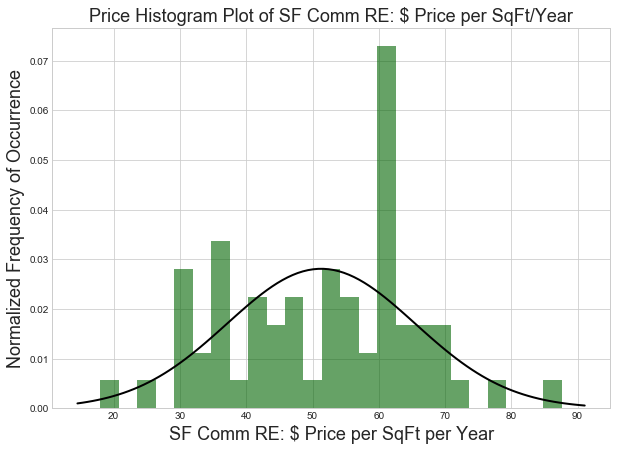

Mean    SF Commercial Real Estate Price: $ per SqFt per Year = $ 51.30
Median  SF Commercial Real Estate Price: $ per SqFt per Year = $ 53.82
Std Dev SF Commercial Real Estate Price: $ per SqFt per Year = $ 14.20

Note to dataset ^ : these prices may be skewed on the low side, because these are _published prices_ for 
  office commercial real estate; these do not include the more _premium unpublished_ real estate location prices.


In [22]:
# Fit a normal distribution to the data:
rcParams['figure.figsize'] = 10, 7
mu, std = norm.fit(y_SFCommRE)
# Plot the histogram (the vertical colored bars).
plt.hist(y_SFCommRE, bins=25, density=True, alpha=0.6, color='darkgreen')
# Plot the Probability Density Function (PDF) (smoothed black curve line).
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)

plt.xlabel('SF Comm RE: $ Price per SqFt per Year', fontsize=18)
plt.ylabel('Normalized Frequency of Occurrence', fontsize=18)
plt.title('Price Histogram Plot of SF Comm RE: $ Price per SqFt/Year', fontsize=18)
plt.show()

print("Mean    SF Commercial Real Estate Price: $ per SqFt per Year = $ "+"{:.2f}".format(np.mean(y_SFCommRE)))
print("Median  SF Commercial Real Estate Price: $ per SqFt per Year = $ "+"{:.2f}".format(np.median(y_SFCommRE)))
print("Std Dev SF Commercial Real Estate Price: $ per SqFt per Year = $ "+"{:.2f}".format(np.std(y_SFCommRE)))
print("\nNote to dataset ^ : these prices may be skewed on the low side, because these are _published prices_ for \n  office commercial real estate; these do not include the more _premium unpublished_ real estate location prices.")

In [23]:
# Plot the SEA Pioneer Square Comercial Real Estate rental prices in a histogram
# Values of 'Price per SqFt/Year' column, from Seattle / Pioneer Square Comm R.E. properties referenced in the .CSV file
y_SEACommRE = SEA_PS_CommRE['Price per SqFt/Year'].sort_values(ascending=True)
y_SEACommRE = y_SEACommRE.replace('[\$,]', '', regex=True).astype(float)
y_SEACommRE = y_SEACommRE.values
x_UnitSeries = np.arange(1, (len(y_SEACommRE)+1), 1)
# print('y_SEACommRE array = \n', y_SEACommRE)
# print('\nx_UnitSeries array = \n', x_UnitSeries)

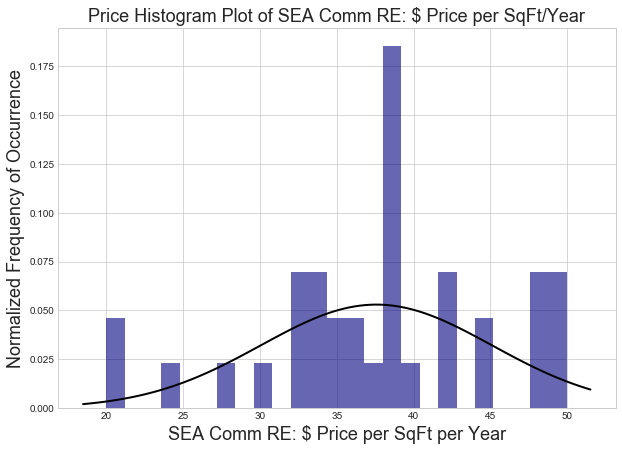

Mean    SEA Commercial Real Estate Price: $ per SqFt per Year = $ 37.58
Median  SEA Commercial Real Estate Price: $ per SqFt per Year = $ 38.00
Std Dev SEA Commercial Real Estate Price: $ per SqFt per Year = $  7.53

Note to dataset ^ : these prices may be skewed on the low side, because these are _published prices_ for 
  office commercial real estate; these do not include the more _premium unpublished_ real estate location prices.


In [24]:
# Fit a normal distribution to the data:
rcParams['figure.figsize'] = 10, 7
mu, std = norm.fit(y_SEACommRE)
# Plot the histogram (the vertical colored bars).
plt.hist(y_SEACommRE, bins=25, density=True, alpha=0.6, color='navy')
# Plot the Probability Density Function (PDF) (the smoothed black curve line).
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)

plt.xlabel('SEA Comm RE: $ Price per SqFt per Year', fontsize=18)
plt.ylabel('Normalized Frequency of Occurrence', fontsize=18)
plt.title('Price Histogram Plot of SEA Comm RE: $ Price per SqFt/Year', fontsize=18)
plt.show()

print("Mean    SEA Commercial Real Estate Price: $ per SqFt per Year = $ "+"{:.2f}".format(np.mean(y_SEACommRE)))
print("Median  SEA Commercial Real Estate Price: $ per SqFt per Year = $ "+"{:.2f}".format(np.median(y_SEACommRE)))
print("Std Dev SEA Commercial Real Estate Price: $ per SqFt per Year = $  "+"{:.2f}".format(np.std(y_SEACommRE)))
print("\nNote to dataset ^ : these prices may be skewed on the low side, because these are _published prices_ for \n  office commercial real estate; these do not include the more _premium unpublished_ real estate location prices.")

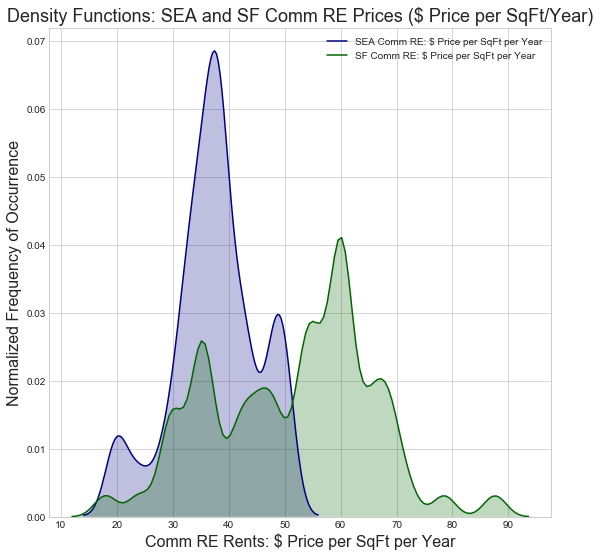

In [25]:
rcParams['figure.figsize'] = 9,9
sns.kdeplot(y_SEACommRE, bw=2, color='navy', shade=True, label="SEA Comm RE: $ Price per SqFt per Year")
sns.kdeplot(y_SFCommRE, bw=2, color = 'darkgreen', shade=True, label="SF Comm RE: $ Price per SqFt per Year")

plt.xlabel('Comm RE Rents: $ Price per SqFt per Year', fontsize=16)
plt.ylabel('Normalized Frequency of Occurrence', fontsize=16)
plt.title('Density Functions: SEA and SF Comm RE Prices ($ Price per SqFt/Year)', fontsize=18)
plt.show()

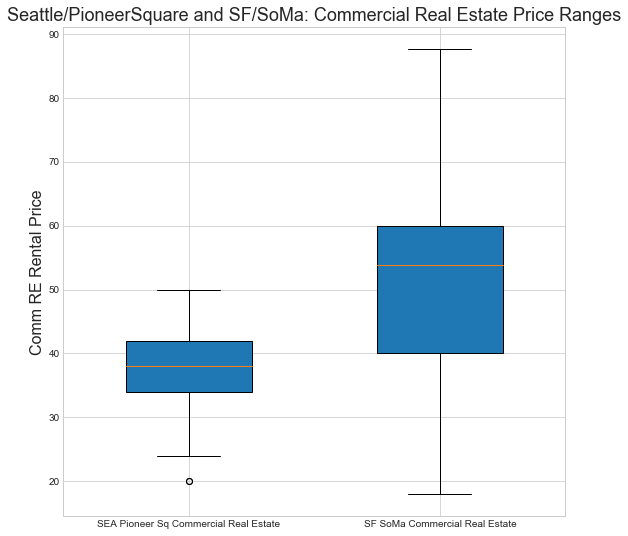

In [26]:
# Generate boxplots of both SF and SEA to show and compare the Comm RE value distributions
# First build the Pandas dataframe with the two neighborhoods, showing the span of Comm RE rental prices for each
#  Result: 2-column dataframe: ['SF_SoMa_Comm_RE', 'SEA_PS_Comm_RE']

rcParams['figure.figsize'] = 9, 9

fig = plt.figure()
plt.title('Seattle/PioneerSquare and SF/SoMa: Commercial Real Estate Price Ranges', fontsize=18)
plt.ylabel('Comm RE Rental Price', fontsize=16)
box_plot_data = [y_SEACommRE, y_SFCommRE]
plt.boxplot(box_plot_data, patch_artist = True, labels = ['SEA Pioneer Sq Commercial Real Estate', 'SF SoMa Commercial Real Estate'], widths=(0.5, 0.5))
plt.show()

State and City Corporate Income Taxes Assessment.
I calculate the C corporation tax impact for two company financial profiles for each neighborhood: 

1. A company with $2M annual revenue and 15 percent Net Income Before Taxes.

2. A company with $10M annual revenue and 15 percent Net Income Before Taxes.

State of California / City of San Francisco Corporate Tax Structure:
1. State of California business tax rate = 8.84% on Corporate Net Income
2. San Francisco Corporate Gross Receipts Tax: scales with sales revenues; 0.46% for $2M sales, 0.51 percent for $10M sales.
3. San Francisco Payroll Expense Tax = 0.38%, for corporate entities with a personnel payroll exceeding $300K/year.

State of Washington / City of Seattle Corporate Tax Structure:
1. State of Washington business tax rate: 1.5% on Corporate Net Income
2. Seattle City Gross Receipts Tax: 0.427% on Gross Receipts.

In [55]:
# Access the .CSV file describing tax structures for California/San Francisco and Washington/Seattle, 
#  and structure in a Pandas dataframe for computation
bizTaxes_SanFran_Seattle = pd.read_csv(filepath_or_buffer='Corporate-Taxes-Scenarios-SFSoMa-and-SeattlePS.csv', sep=',')
bizTaxes_SanFran_Seattle.columns = ['Corporate Item', 'Corp Financial Result', 'CA State Corp Tax', 'SF: Gross Receipts Tax', 'SF: Payroll Expense Tax', 'CA/SF Tax Computation', 'WA State Corp Tax', 'Seattle City Tax', 'WA/Seattle Tax Computation']
bizTaxes_SanFran_Seattle

,Corporate Item,Corp Financial Result,CA State Corp Tax,SF: Gross Receipts Tax,SF: Payroll Expense Tax,CA/SF Tax Computation,WA State Corp Tax,Seattle City Tax,WA/Seattle Tax Computation
0,Corp Sales @ $2M,"$2,000,000",0,0.46%,0,$0,0,0.43%,$0
1,Payroll Expense @ 50% of Sales,"$1,000,000",0,0,0.38%,$0,0,0,$0
2,Profit Before Tax @ 15% of Sales,"$300,000",8.84%,0,0,$0,1.50%,0,$0
3,Tax Computation,$0,0,0,0,"$39,520",0,0,"$13,040"
4,Corp Sales @ $10M,"$10,000,000",0,0.51%,0,$0,0,0.43%,$0
5,Payroll Expense @ 50% of Sales,"$5,000,000",0,0,0.38%,$0,0,0,$0
6,Profit Before Tax @ 15% of Sales,"$1,500,000",8.84%,0,0,$0,1.50%,0,$0
7,Tax Computation,$0,0,0,0,"$202,600",0,0,"$65,200"


Generate a multi-bar chart -- corporate tax computations for each of: $2M company, $10M company

In [56]:
# Dataframe.loc[["row1", "row2"], ["column1", "column2", "column3"]]
bizTaxes_df = pd.DataFrame(bizTaxes_SanFran_Seattle[['Corporate Item', 'Corp Financial Result', 'CA/SF Tax Computation', 'WA/Seattle Tax Computation']])
bizTaxes_df = bizTaxes_df.iloc[[0,3,4,7],:]
bizTaxes_df.iloc[0,2:4] = bizTaxes_df.iloc[1, 2:4]
bizTaxes_df.iloc[2,2:4] = bizTaxes_df.iloc[3, 2:4]
bizTaxes_df = bizTaxes_df.iloc[[0, 2],:]
bizTaxes_df

,Corporate Item,Corp Financial Result,CA/SF Tax Computation,WA/Seattle Tax Computation
0,Corp Sales @ $2M,"$2,000,000","$39,520","$13,040"
4,Corp Sales @ $10M,"$10,000,000","$202,600","$65,200"


In [57]:
bizTaxes_df['Corp Financial Result'] = bizTaxes_df['Corp Financial Result'].replace('[\$,]', '', regex=True).astype(int)
bizTaxes_df['CA/SF Tax Computation'] = bizTaxes_df['CA/SF Tax Computation'].replace('[\$,]', '', regex=True).astype(int)
bizTaxes_df['WA/Seattle Tax Computation'] = bizTaxes_df['WA/Seattle Tax Computation'].replace('[\$,]', '', regex=True).astype(int)

bizTaxes_df = bizTaxes_df.reset_index(drop=True)
bizTaxes_df

,Corporate Item,Corp Financial Result,CA/SF Tax Computation,WA/Seattle Tax Computation
0,Corp Sales @ $2M,2000000,39520,13040
1,Corp Sales @ $10M,10000000,202600,65200


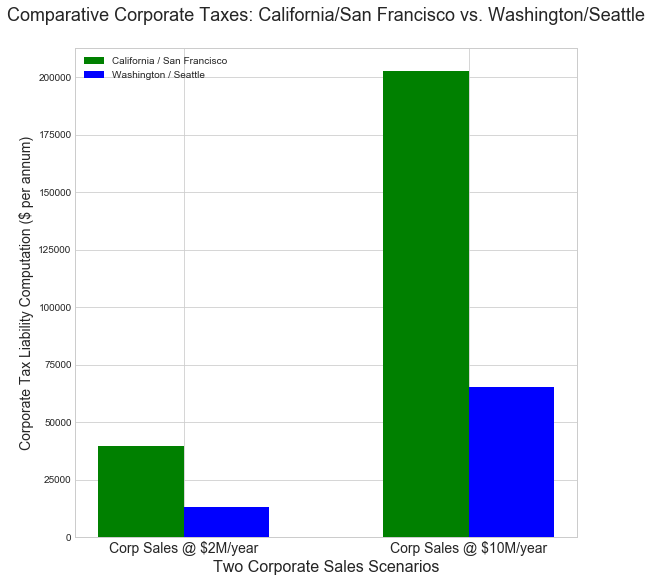

In [58]:
fig, ax = plt.subplots()
index = np.arange(2)
bar_width = 0.3
rcParams['figure.figsize'] = 9, 9

ax.bar(index, bizTaxes_df['CA/SF Tax Computation'], bar_width, color='g', label='California / San Francisco')
ax.bar(index+bar_width, bizTaxes_df['WA/Seattle Tax Computation'], bar_width, color='b', label='Washington / Seattle')

ax.set_xlabel('Two Corporate Sales Scenarios', fontsize=16)
ax.set_ylabel('Corporate Tax Liability Computation ($ per annum)', fontsize=14)
ax.set_title('Comparative Corporate Taxes: California/San Francisco vs. Washington/Seattle\n', fontsize=18)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(['Corp Sales @ $2M/year','Corp Sales @ $10M/year'], fontsize=14)
ax.legend()
plt.show()

Results: Business Location Decision Analysis for Two Neighborhoods: SF / SoMa District and Seattle / Pioneer Square
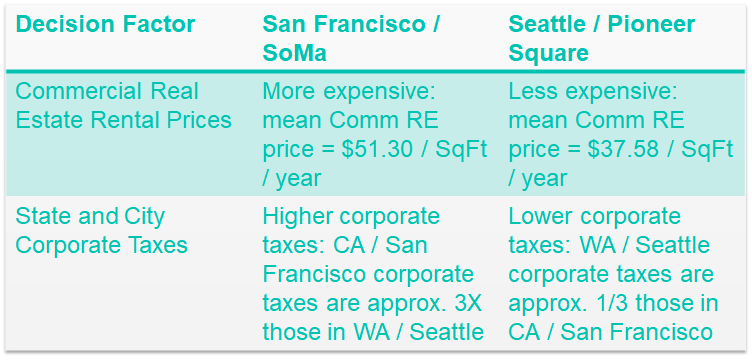

Discussion of Results

Based on the analysis above, Seattle / Pioneer Square contributes a significantly lower corporate financial cost and shows to be a more attractive technology startup business location.

However, there are clearly additional factors to consider for the location of a technology-based professional services company startup, especially:
1. Access to skilled technology personnel to staff the specific business
2. If the firm is venture capital funded, then the VCs' preferences for location are clearly important

Conclusion - Battle of the Neighborhoods: Decision on Where to Locate a Professional Services Business

Decision on Where to Locate a Professional Services Business:

Based on the analysis in this data science study on where to locate a professional services company, I would prioritize locating the professional services business in Seattle / Pioneer Square, a location with a significantly lower corporate costs than in San Francisco.